  ## Author
  Joel Bandstra  
  10/10/2023  
  
  ## Purpose
  Perform global fitting of a first-order reaction network model to a series of experiments where time-series concentration data were collected on dissolved chlorinated ethenes reacting with several forms and doses of zero valent iron. 

  ## Note: This is the S = 0.02 Dataset
  Other levels of sulfidation are handled in seperate files.


## Import libraries needed and read data files

In [1]:
# dependencies
%matplotlib inline
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.linalg import expm

# data import

# ## S = 0.00
# file_mZVIbm = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.00)-mZVIbm-background corrected-2021.03.10-4places.xlsx'
# dict_mZVIbm = pd.read_excel(file_mZVIbm, sheet_name=None)
# sheet_names = list(dict_mZVIbm.keys())[:-1]

## S = 0.02, 
file_mZVIbm = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.02)-mZVIbm-background corrected-2023.09.25-4places.xlsx'
dict_mZVIbm = pd.read_excel(file_mZVIbm, sheet_name=None)
sheet_names = list(dict_mZVIbm.keys())[:-1]
for df_temp in dict_mZVIbm.values(): # remove the S(0.02 from the column names for compatability)
    df_temp.columns = [txt.strip('S(0.02)-') for txt in df_temp.columns]

# ## S = 0.05
# file_mZVIbm_0_05 = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.05)-mZVIbm-background corrected-2023.09.25-4places.xlsx'
# dict_mZVIbm_0_05 = pd.read_excel(file_mZVIbm_0_05, sheet_name=None)
# sheet_names_0_05 = list(dict_mZVIbm_0_05.keys())[:-1]
# for df_temp in dict_mZVIbm.values(): # remove the S(0.05 from the column names for compatability)
#     df_temp.columns = [txt.strip('S(0.02)-') for txt in df_temp.columns]

# ## S = 0.10
# file_mZVIbm_0_10 = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.10)-mZVIbm-background corrected-2021.01.13b-4places.xlsx'
# dict_mZVIbm_0_10 = pd.read_excel(file_mZVIbm_0_10, sheet_name=None)
# sheet_names_0_10 = list(dict_mZVIbm_0_10.keys())[:-1]
# for df_temp in dict_mZVIbm.values(): # remove the S(0.10 from the column names for compatability)
#     df_temp.columns = [txt.strip('S(0.10)-') for txt in df_temp.columns]

# ## S = 0.20
# file_mZVIbm_0_20 = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.20)-mZVIbm-background corrected-2023.09.25-4places.xlsx'
# dict_mZVIbm_0_20 = pd.read_excel(file_mZVIbm_0_20, sheet_name=None)
# sheet_names_0_20 = list(dict_mZVIbm_0_20.keys())[:-1]
# for df_temp in dict_mZVIbm.values(): # remove the S(0.20 from the column names for compatability)
#     df_temp.columns = [txt.strip('S(0.20)-') for txt in df_temp.columns]


In [2]:
dict_mZVIbm[sheet_names[0]]

,mZVIbm_PCE_Time_hr,mZVIbm_PCE_PCE_mM,mZVIbm_PCE_PCE_SD,mZVIbm_PCE_TCE_mM,mZVIbm_PCE_TCE_SD,mZVIbm_PCE_DCEs_mM,mZVIbm_PCE_DCEs_SD,mZVIbm_PCE_tDCE_mM,mZVIbm_PCE_tDCE_SD,mZVIbm_PCE_cDCE_mM,...,mZVIbm_PCE_VC_mM,mZVIbm_PCE_VC_SD,mZVIbm_PCE_Ethene_mM,mZVIbm_PCE_Ethene_SD,mZVIbm_PCE_Ethane_mM,mZVIbm_PCE_Ethane_SD,mZVIbm_PCE_Acetylene_mM,mZVIbm_PCE_Acetylene_SD,mZVIbm_PCE_C3toC6_mM,mZVIbm_PCE_C3toC6_SD
0,0,0.098542,0.000658,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,...,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12,0.090948,0.000092,0.000957,0.000056,0.000000,0.000000,0,0,0.000000,...,0,0,0.002147,0.000074,0.001755,0.000094,0.001543,0.000047,0.000354,0.000143
2,24,0.080859,0.000672,0.000831,0.000097,0.000000,0.000000,0,0,0.000000,...,0,0,0.004694,0.000026,0.003185,0.000222,0.002756,0.000320,0.000487,0.000047
3,72,0.057055,0.000030,0.000627,0.000197,0.000471,0.000005,0,0,0.000471,...,0,0,0.012119,0.000501,0.006833,0.000276,0.004782,0.000063,0.000710,0.000221
4,120,0.042924,0.000722,0.000000,0.000000,0.001191,0.000074,0,0,0.000819,...,0,0,0.018562,0.000352,0.010040,0.000068,0.004290,0.000155,0.001029,0.000115
5,168,0.029906,0.000168,0.000000,0.000000,0.001280,0.000047,0,0,0.000975,...,0,0,0.024488,0.000957,0.012771,0.000119,0.001807,0.000341,0.001012,0.000014
6,240,0.015063,0.000016,0.000000,0.000000,0.001059,0.000150,0,0,0.000712,...,0,0,0.026781,0.000037,0.014915,0.000157,0.000730,0.000047,0.001086,0.000012
7,360,0.003271,0.000233,0.000000,0.000000,0.000414,0.000148,0,0,0.000216,...,0,0,0.039076,0.007446,0.019226,0.001871,0.001363,0.001213,0.001244,0.000291



  ## Theoretical background 
  
  The experimental data consist of several different initial ethenes (e.g., PCE, TCE, DCE's etc.) and both the reactant and several intermediates/products were monitored over time.  

  The reaction scheme shown below represents the network of first order reactions included in the model.  

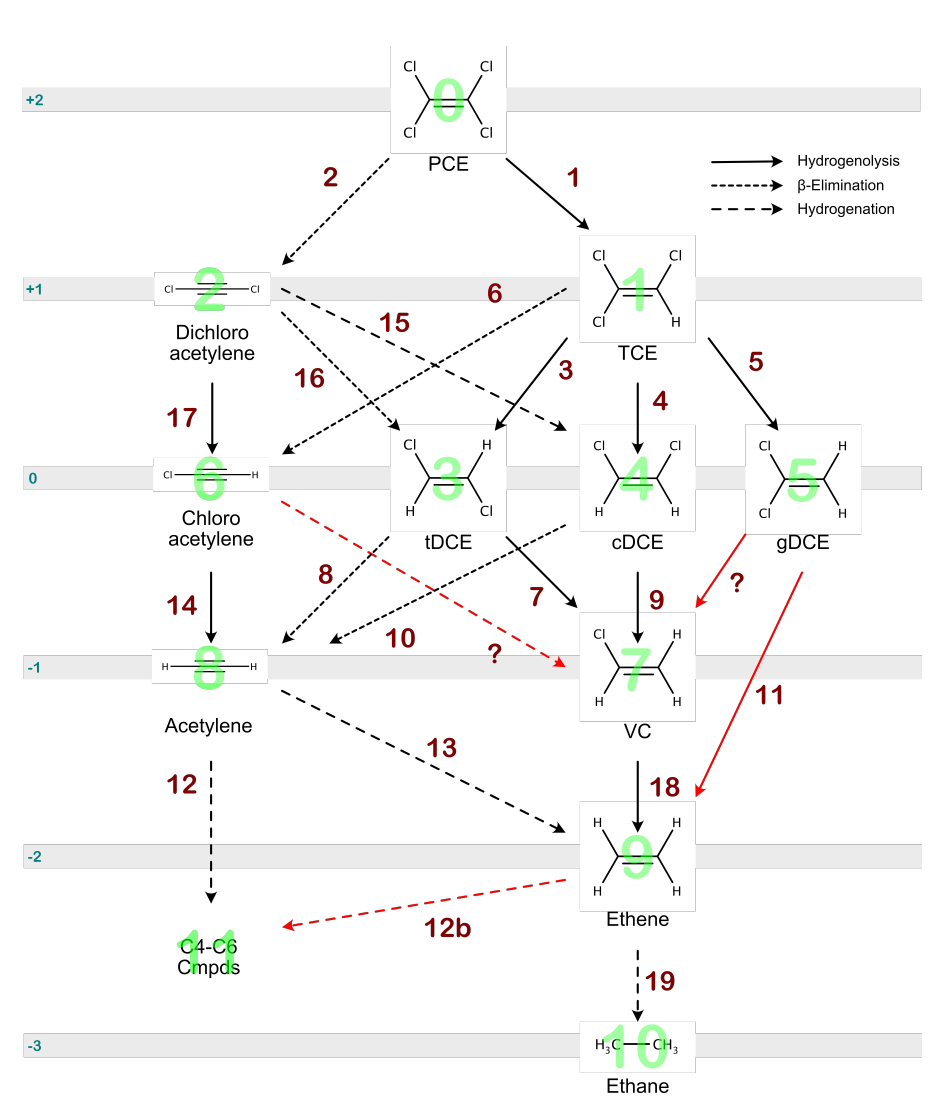

  ## Model Formulation
  Assuming that all of the reactions represented above are first-order and irreversible and that a first-order, reversible partitioning process accounts for loss of mass balance, a system of ODE's can be written as:  
  
  $\begin{aligned}
\frac{dC_0}{dt} &= -(k_1 + k_2 + k_{Lf})\cdot C_0 + k_{Lb} \cdot C_{12}\\
\frac{dC_1}{dt} &= +k_1 \cdot C_0 - (k_3 + k_4 + k_5 + k_6 + k_{Lf}) \cdot C_1 + k_{Lb} \cdot C_{13}\\
\frac{dC_2}{dt} &= +k_2 \cdot C_0 - (k_{15} + k_{16} + k_{17} + k_{Lf}) \cdot C_2 + k_{Lb} \cdot C_{14}\\
\frac{dC_3}{dt} &= +k_3 \cdot C_1 + k_{16} \cdot C_2 - (k_7 + k_8 + k_{Lf}) \cdot C_3 + k_{Lb} \cdot C_{15}\\
\frac{dC_4}{dt} &= +k_4 \cdot C_1 + k_{15} \cdot C_2 - (k_9 + k_{10} + k_{Lf}) \cdot C_4 + k_{Lb} \cdot C_{16}\\
\frac{dC_5}{dt} &= +k_5 \cdot C_1 - (k_{11} + k_{11b} + k_{Lf}) \cdot C_5 + k_{Lb} \cdot C_{17} \\
\frac{dC_6}{dt} &= +k_6 \cdot C_1 + k_{17} \cdot C_2 -(k_{13b} + k_{14} + k_{Lf}) \cdot C_6 + k_{Lb} \cdot C_{18} \\
\frac{dC_7}{dt} &= +k_7 \cdot C_3 + k_9 \cdot C_4 + k_{11b} \cdot C_5 + k_{13b} \cdot C_6 - (k_{18} + k_{Lf}) \cdot C_7 + k_{Lb} \cdot C_{19} \\
\frac{dC_8}{dt} &= +k_8 \cdot C_3 + k_{10} \cdot C_4 + k_{14} \cdot C_6 - (k_{12} + k_{13} + k_{13c} + k_{Lf}) \cdot C_8 + k_{Lb} \cdot C_{20} \\
\frac{dC_9}{dt} &= +k_{11} \cdot C_5 + k_{18} \cdot C_7 + k_{13} \cdot C_8 - (k_{12b} + k_{19} + k_{Lf}) \cdot C_9 + k_{Lb} \cdot C_{21} \\
\frac{dC_{10}}{dt} &= +k_{13c} \cdot C_8 + k_{19} \cdot C_9 - k_{Lf} \cdot C_{10} + k_{Lb} \cdot C_{22} \\
\frac{dC_{11}}{dt} &= +k_{12} \cdot C_8 + k_{12b} \cdot C_9 - k_{Lf} \cdot C_{11} + k_{Lb} \cdot C_{23} \\
\frac{dC_{12}}{dt} &= +k_{Lf} \cdot C_0 - k_{Lb} \cdot C_{12} \\
\frac{dC_{13}}{dt} &= +k_{Lf} \cdot C_1 - k_{Lb} \cdot C_{13} \\
\frac{dC_{14}}{dt} &= +k_{Lf} \cdot C_2 - k_{Lb} \cdot C_{14} \\
\frac{dC_{15}}{dt} &= +k_{Lf} \cdot C_3 - k_{Lb} \cdot C_{15} \\
\frac{dC_{16}}{dt} &= +k_{Lf} \cdot C_4 - k_{Lb} \cdot C_{16} \\
\frac{dC_{17}}{dt} &= +k_{Lf} \cdot C_5 - k_{Lb} \cdot C_{17} \\
\frac{dC_{18}}{dt} &= +k_{Lf} \cdot C_6 - k_{Lb} \cdot C_{18} \\
\frac{dC_{19}}{dt} &= +k_{Lf} \cdot C_7 - k_{Lb} \cdot C_{19} \\
\frac{dC_{20}}{dt} &= +k_{Lf} \cdot C_8 - k_{Lb} \cdot C_{20} \\
\frac{dC_{21}}{dt} &= +k_{Lf} \cdot C_9 - k_{Lb} \cdot C_{21} \\
\frac{dC_{22}}{dt} &= +k_{Lf} \cdot C_{10} - k_{Lb} \cdot C_{22} \\
\frac{dC_{23}}{dt} &= +k_{Lf} \cdot C_{11} - k_{Lb} \cdot C_{23} \\
  \end{aligned}$

  where concentration and rate constant numbering scheme is represented in reaction network diagram and $k_{Lf}$ and $k_{Lb}$ represent rate forward and backward rate constants, respectively, for a kinetic partitioning process intended to unbias fitting results in the face of incomplete mass balance (presumably due to some combination of partitioning processes out of the aqeuous phase).  

  ## Matrix Formulation
  The kinetic model above can be formulated in matrix form as:  
  $
\dot{C} = \vec{A} \cdot \vec{C}
  $

  where $\vec{C}$ is the vector of concentrations, $\dot{C}$ is the time derivtive of the concentrations, and $\vec{A}$ is a coeficient matrix comprised of rate constant terms given by:
  
  $
\vec{A} = 
  $

  
  $
\tiny \begin{matrix}
-(k_1 + k_2 + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
k_1 & -(k_3 + k_4 + k_5 + k_6 + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
k_2 & 0 & -(k_{15} + k_{16} + k_{17} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_3 & k_{16} & -(k_7 + k_8 + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_4 & k_{15} & 0 & -(k_9 + k_{10} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_5 & 0 & 0 & 0 & -(k_{11} + k_{11b} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_6 & k_{17} & 0 & 0 & 0 & -(k_{13b} + k_{14} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & k_7 & k_9 & k_{11b} & k_{13b} & -(k_{18} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & k_8 & k_{10} & 0 & k_{14} & 0 & -(k_{12} + k_{13} + k_{13c} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & k_{11} & 0 & k_{18} & k_{13} & -(k_{12b} + k_{19} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{13c} & k_{19} & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{12} & k_{12b} & 0 & -k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} \\
k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb}
\end{matrix}
  $


## Solution method
The system of ODE's expressed above can be solved using the matrix exponential function along with a suitable initial condition. This approach is exemplified in the local fits of degredation data with unsulfidated ZVI.

## Local Fits for each parent compound

In [3]:
# Utility function 
# to compute the A matrix from an array of rate constants
def Calc_A(karr):
    # unpack karr
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k11b, k12, k12b, k13, k13b, k13c, k14, k15, k16, k17, k18, k19, kLf, kLb = karr
    A = np.zeros((24,24))
    # PCE
    A[0,0] = -(k1 + k2 + kLf)
    A[0,12] = +kLb
    # TCE
    A[1,0] = +k1
    A[1,1] = -(k3 + k4 + k5 + k6 + kLf)
    A[1,13] = +kLb
    # DCA
    A[2,0] = +k2
    A[2,2] = -(k15 + k16 + k17 + kLf)
    A[2,14] = +kLb
    # tDCE
    A[3,1] = +k3
    A[3,2] = +k16
    A[3,3] = -(k7 + k8 + kLf)
    A[3,15] = +kLb
    # cDCE
    A[4,1] = +k4
    A[4,2] = +k15
    A[4,4] = -(k9 + k10 + kLf)
    A[4,16] = +kLb
    # 11DCE (gDCE)
    A[5,1] = +k5
    A[5,5] = -(k11 + k11b + kLf)
    A[5,17] = +kLb
    # chloroacetylene
    A[6,1] = +k6
    A[6,2] = +k17
    A[6,6] = -(k13b + k14 + kLf)
    A[6,18] = +kLb
    # VC
    A[7,3] = +k7
    A[7,4] = +k9
    A[7,5] = +k11b
    A[7,6] = +k13b
    A[7,7] = -(k18 + kLf)
    A[7,19] = +kLb
    # Acetylene
    A[8,3] = +k8
    A[8,4] = +k10
    A[8,6] = +k14
    A[8,8] = -(k12 + k13 + k13c + kLf)
    A[8,20] = +kLb
    # Ethene
    A[9,5] = +k11
    A[9,7] = +k18
    A[9,8] = +k13
    A[9,9] = -(k12b + k19 + kLf)
    A[9,21] = +kLb
    # Ethane
    A[10,8] = +k13c
    A[10,9] = +k19
    A[10,10] = -kLf
    A[10,22] = +kLb
    # C3-C6 compounds
    A[11,8] = +k12
    A[11,9] = +k12b
    A[11,11] = -kLf
    A[11,23] = +kLb
    # Lost mass
    A[12,0], A[12,12] = kLf, -kLb
    A[13,1], A[13,13] = kLf, -kLb
    A[14,2], A[14,14] = kLf, -kLb
    A[15,3], A[15,15] = kLf, -kLb
    A[16,4], A[16,16] = kLf, -kLb
    A[17,5], A[17,17] = kLf, -kLb
    A[18,6], A[18,18] = kLf, -kLb
    A[19,7], A[19,19] = kLf, -kLb
    A[20,8], A[20,20] = kLf, -kLb
    A[21,9], A[21,21] = kLf, -kLb
    A[22,10], A[22,22] = kLf, -kLb
    A[23,11], A[23,23] = kLf, -kLb
    return A

In [4]:
# Index for local fits
coef_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb', 'C_0']

#### Local Fit of PCE (and daughter products)

In [5]:
# PCE and daughter products
def PCE(params, tarr):
    #first 25 params are k's, Then Cinit_i = params[25+i]
    
    # Run model
    A = Calc_A(params[0:25])
    C0 = np.zeros(24)
    C0[0] = params[25+0]
    Coef = np.linalg.solve(expm(0*A), C0)
    C = np.array([np.dot(expm(a),Coef) for a in [t * A for t in tarr]])
    
    # Organize model results
    PCEmodel = C[:,0]
    TCEmodel = C[:,1]
    tDCEmodel = C[:,3]
    cDCEmodel = C[:,4]
    gDCEmodel = C[:,5]
    VCmodel = C[:,7]
    Ethenemodel = C[:,9]
    Ethanemodel = C[:,10]
    Acetylenemodel = C[:,8]
    C3toC6model = C[:,11]
    
    # Return Results
    return PCEmodel, TCEmodel, tDCEmodel, cDCEmodel, gDCEmodel, VCmodel, Ethenemodel, Ethanemodel, Acetylenemodel, C3toC6model
    
def PCEfitfunc(params):
    #first 25 params are k's, Then Cinit_i = params[26+i]
    
    # Organize data
    tdata = dict_mZVIbm['PCE']['mZVIbm_PCE_Time_hr']
    PCEdata = dict_mZVIbm['PCE']['mZVIbm_PCE_PCE_mM']
    TCEdata = dict_mZVIbm['PCE']['mZVIbm_PCE_TCE_mM']
    tDCEdata = dict_mZVIbm['PCE']['mZVIbm_PCE_tDCE_mM']
    cDCEdata = dict_mZVIbm['PCE']['mZVIbm_PCE_cDCE_mM']
    gDCEdata = dict_mZVIbm['PCE']['mZVIbm_PCE_1,1-DCE_mM']
    VCdata = dict_mZVIbm['PCE']['mZVIbm_PCE_VC_mM']
    Ethenedata = dict_mZVIbm['PCE']['mZVIbm_PCE_Ethene_mM']
    Ethanedata = dict_mZVIbm['PCE']['mZVIbm_PCE_Ethane_mM']
    Acetylenedata = dict_mZVIbm['PCE']['mZVIbm_PCE_Acetylene_mM']
    C3toC6data = dict_mZVIbm['PCE']['mZVIbm_PCE_C3toC6_mM']
    
    # Run model
    PCEmodel, TCEmodel, tDCEmodel, cDCEmodel, gDCEmodel, VCmodel, Ethenemodel, Ethanemodel, Acetylenemodel, C3toC6model = PCE(params, tdata)

    # Formulate Residuals
    Resids = np.array([PCEdata - PCEmodel,
                      TCEdata - TCEmodel,
                      tDCEdata - tDCEmodel,
                      cDCEdata - cDCEmodel,
                      gDCEdata - gDCEmodel,
                      VCdata - VCmodel,
                      Ethenedata - Ethenemodel,
                      Ethanedata - Ethanemodel,
                      Acetylenedata - Acetylenemodel,
                      C3toC6data - C3toC6model])
    return Resids.flatten()

Text(0.5, 1.0, 'Initial guesses for PCE and daughter products')

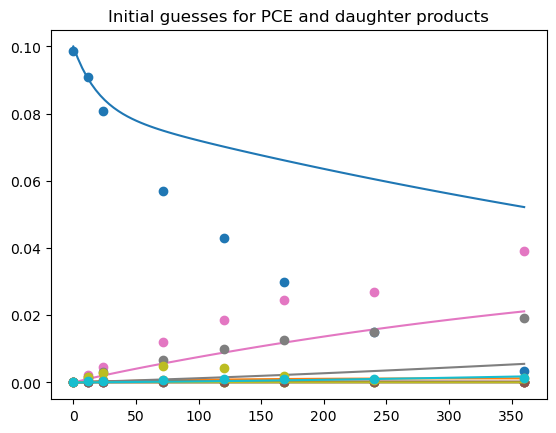

In [6]:
# Initial Guesses
karr = [0.000154913,
0.001351431,
1.66E-22,
1.25E-05,
0.000169865,
0.006572788,
0.004576002,
0.030211386,
0.010104698,
0.01538538,
0.005465666,
0,
0.070925877,
0.00031306,
2.148707611,
280.4961721,
0.325455601,
1652.376696,
7.21E-09,
8.92E-09,
6342.834443,
0.047280383,
0.000666284,
0.009,
0.041665372
]
C0 = np.zeros(1)
C0[0] = 0.1



tdata = dict_mZVIbm['PCE']['mZVIbm_PCE_Time_hr']
lst1 =  dict_mZVIbm[sheet_names[0]].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm[sheet_names[0]].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = PCE(np.hstack((karr, C0)), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],2), C)):
    plt.plot(tdata, dict_mZVIbm['PCE'][name], 'o', color=colors[i])
    plt.plot(tarr, conc, color=colors[i])
plt.title('Initial guesses for PCE and daughter products')

In [7]:
# Perform Fit
PCEfit = least_squares(PCEfitfunc, np.hstack((karr, C0)), bounds=(0, np.inf))
# print(PCEfit.x)

# Compute std errors
J = PCEfit.jac
chi2dof = np.sum(PCEfit.fun**2)/(PCEfit.fun.size - PCEfit.x.size)
cov = np.linalg.inv(J.T.dot(J))*chi2dof
err = np.sqrt(np.diagonal(cov))
# print(err)

# Print results
pd.DataFrame({'Fitted Coefs':PCEfit.x, 'Std. Err.':err}, index=coef_names)
# pd.DataFrame(J.T.dot(J)).to_clipboard(index=False, header=False)

,Fitted Coefs,Std. Err.
k1,1.063354e-03,1.305429e-03
k2,4.865218e-03,1.334575e-03
k3,1.042803e-03,1.043421e-01
k4,1.968323e-02,7.746201e-02
k5,1.636387e-02,2.861930e-02
k6,9.042603e-05,1.291671e-01
k7,2.323972e-04,4.944284e-01
k8,1.411016e-02,5.034227e-01
k9,6.538502e-03,2.426266e-01
k10,7.782874e-03,2.429123e-01


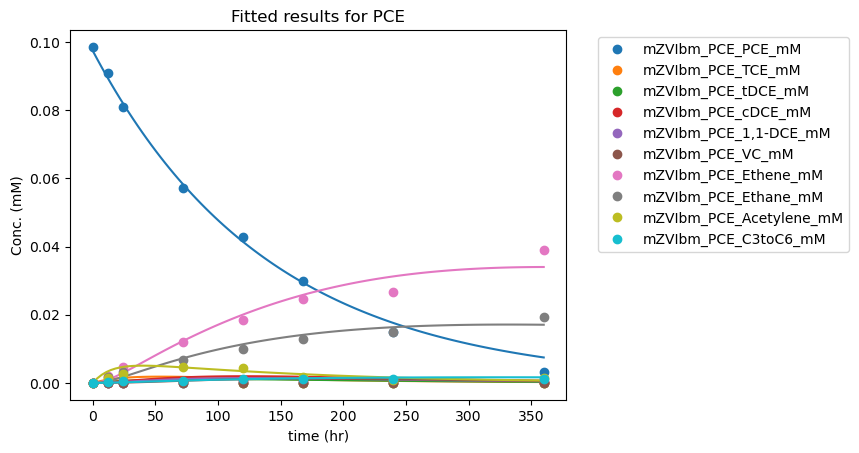

In [8]:
tdata = dict_mZVIbm['PCE']['mZVIbm_PCE_Time_hr']
lst1 =  dict_mZVIbm[sheet_names[0]].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm[sheet_names[0]].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = PCE(PCEfit.x, tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],2), C)):
    plt.plot(tdata, dict_mZVIbm['PCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.title('Fitted results for PCE')
# plt.savefig('Local_Corrected mZVIbm_PCE.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],2), C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
# df.to_csv('Local_Corrected mZVIbm_PCE.csv',index=False)

In [9]:
local_fit_df = pd.DataFrame({'PCE Fit':PCEfit.x}, index=coef_names)


#### Local fit of TCE

In [10]:
# TCE and daughter products
def TCE(params, tarr):
    #first 25 params are k's, Then Cinit_i = params[25]
    
    # Run model
    A = Calc_A(params[0:25])
    C0 = np.zeros(24)
    C0[1] = params[25]
    Coef = np.linalg.solve(expm(0*A), C0)
    C = np.array([np.dot(expm(a),Coef) for a in [t * A for t in tarr]])
    
    # Organize model results
    TCEmodel = C[:,1]
    tDCEmodel = C[:,3]
    cDCEmodel = C[:,4]
    gDCEmodel = C[:,5]
    VCmodel = C[:,7]
    Ethenemodel = C[:,9]
    Ethanemodel = C[:,10]
    Acetylenemodel = C[:,8]
    C3toC6model = C[:,11]
    
    # Return Results
    return TCEmodel, tDCEmodel, cDCEmodel, gDCEmodel, VCmodel, Ethenemodel, Ethanemodel, Acetylenemodel, C3toC6model
    
def TCEfitfunc(params):
    #first 25 params are k's, Then Cinit_i = params[26+i]
    
    # Organize data
    tdata = dict_mZVIbm['TCE']['mZVIbm_TCE_Time_hr']
    TCEdata = dict_mZVIbm['TCE']['mZVIbm_TCE_TCE_mM']
    tDCEdata = dict_mZVIbm['TCE']['mZVIbm_TCE_tDCE_mM']
    cDCEdata = dict_mZVIbm['TCE']['mZVIbm_TCE_cDCE_mM']
    gDCEdata = dict_mZVIbm['TCE']['mZVIbm_TCE_1,1-DCE_mM']
    VCdata = dict_mZVIbm['TCE']['mZVIbm_TCE_VC_mM']
    Ethenedata = dict_mZVIbm['TCE']['mZVIbm_TCE_Ethene_mM']
    Ethanedata = dict_mZVIbm['TCE']['mZVIbm_TCE_Ethane_mM']
    Acetylenedata = dict_mZVIbm['TCE']['mZVIbm_TCE_Acetylene_mM']
    C3toC6data = dict_mZVIbm['TCE']['mZVIbm_TCE_C3toC6_mM']
    
    # Run model
    TCEmodel, tDCEmodel, cDCEmodel, gDCEmodel, VCmodel, Ethenemodel, Ethanemodel, Acetylenemodel, C3toC6model = TCE(params, tdata)

    # Formulate Residuals
    Resids = np.array([TCEdata - TCEmodel,
                      tDCEdata - tDCEmodel,
                      cDCEdata - cDCEmodel,
                      gDCEdata - gDCEmodel,
                      VCdata - VCmodel,
                      Ethenedata - Ethenemodel,
                      Ethanedata - Ethanemodel,
                      Acetylenedata - Acetylenemodel,
                      C3toC6data - C3toC6model])
    return Resids.flatten()
def TCEfitfuncReduced(params_red):
    params = np.hstack(([0,0], params_red[0:13], [0,0,0], params_red[13:]))
    return TCEfitfunc(params)

Text(0.5, 1.0, 'Initial guesses for TCE')

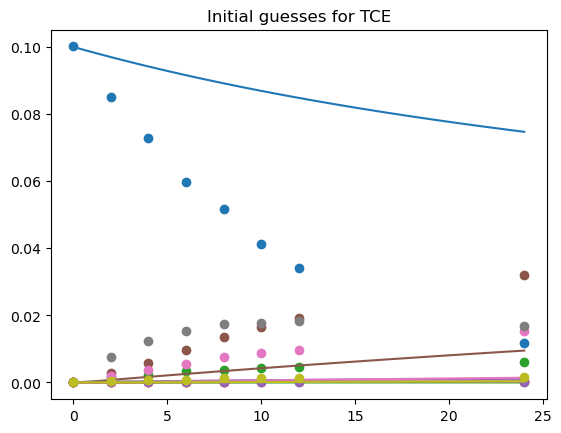

In [11]:
# Initial Guesses
karr = [0.000154913,
0.001351431,
1.66E-22,
1.25E-05,
0.000169865,
0.006572788,
0.004576002,
0.030211386,
0.010104698,
0.01538538,
0.005465666,
0,
0.070925877,
0.00031306,
2.148707611,
280.4961721,
0.325455601,
1652.376696,
7.21E-09,
8.92E-09,
6342.834443,
0.047280383,
0.000666284,
0.009,
0.041665372
]
C0 = np.zeros(1)
C0[0] = 0.1



tdata = dict_mZVIbm['TCE']['mZVIbm_TCE_Time_hr']
lst1 =  dict_mZVIbm['TCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['TCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = TCE(np.hstack((karr, C0)), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],1), C)):
    plt.plot(tdata, dict_mZVIbm['TCE'][name], 'o', color=colors[i])
    plt.plot(tarr, conc, color=colors[i])

plt.title('Initial guesses for TCE')

In [12]:
# Perform Fit
TCEfit = least_squares(TCEfitfunc, np.hstack((karr, C0)), bounds=(0, np.inf))
# print(TCEfit.x)

# Compute std errors
try:
    J = TCEfit.jac
    chi2dof = np.sum(TCEfit.fun**2)/(TCEfit.fun.size - TCEfit.x.size)
    cov = np.linalg.inv(J.T.dot(J))*chi2dof
    err = np.sqrt(np.diagonal(cov))
except:
    err = np.zeros_like(TCEfit)*np.NaN
# print(err)

# Print results
coef_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb', 'C_0']
pd.DataFrame({'Fitted Coefs':TCEfit.x, 'Std. Err.':err}, index=coef_names)
# pd.DataFrame(J.T.dot(J)).to_clipboard(index=False, header=False)

,Fitted Coefs,Std. Err.
k1,19728.547565,NaN
k2,2927.327380,NaN
k3,0.004351,NaN
k4,0.009300,NaN
k5,0.015602,NaN
k6,0.047819,NaN
k7,1.661353,NaN
k8,0.000655,NaN
k9,0.000002,NaN
k10,0.037812,NaN


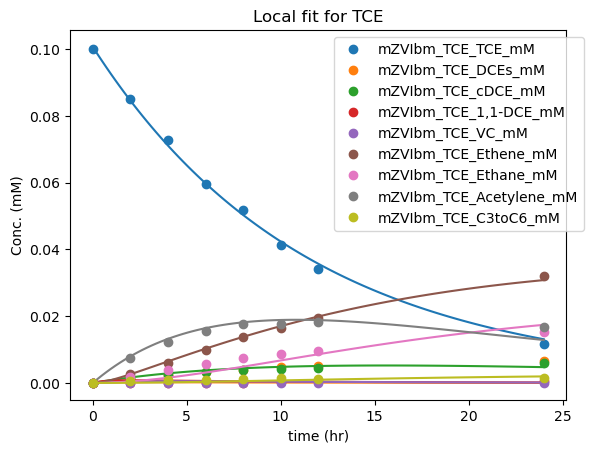

In [13]:
tdata = dict_mZVIbm['TCE']['mZVIbm_TCE_Time_hr']
lst1 =  dict_mZVIbm['TCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['TCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = TCE(TCEfit.x, tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],2), C)):
    plt.plot(tdata, dict_mZVIbm['TCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
# plt.savefig('Local_Corrected mZVIbm_TCE.png',bbox_inches ="tight")
plt.title('Local fit for TCE')

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],1), C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
# df.to_csv('Local_Corrected mZVIbm_TCE.csv',index=False)

In [14]:
local_fit_df['TCE Fit'] = TCEfit.x

#### Local fit for tDCE

In [15]:
# TCE and daughter products
def tDCE(params, tarr):
    #first 25 params are k's, Then Cinit_i = params[25]
    
    # Run model
    A = Calc_A(params[0:25])
    C0 = np.zeros(24)
    C0[3] = params[25]
    Coef = np.linalg.solve(expm(0*A), C0)
    C = np.array([np.dot(expm(a),Coef) for a in [t * A for t in tarr]])
    
    # Organize model results
    tDCEmodel = C[:,3]
    VCmodel = C[:,7]
    Ethenemodel = C[:,9]
    Ethanemodel = C[:,10]
    Acetylenemodel = C[:,8]
    C3toC6model = C[:,11]
    
    # Return Results
    return tDCEmodel, VCmodel, Ethenemodel, Ethanemodel, Acetylenemodel, C3toC6model
    
def tDCEfitfunc(params):
    #first 25 params are k's, Then Cinit_i = params[26+i]
    
    # Organize data
    tdata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_Time_hr']
    
    tDCEdata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_tDCE_mM']
    
    VCdata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_VC_mM']
    Ethenedata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_Ethene_mM']
    Ethanedata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_Ethane_mM']
    Acetylenedata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_Acetylene_mM']
    C3toC6data = dict_mZVIbm['tDCE']['mZVIbm_tDCE_C3toC6_mM']
    
    # Run model
    tDCEmodel, VCmodel, Ethenemodel, Ethanemodel, Acetylenemodel, C3toC6model = tDCE(params, tdata)

    # Formulate Residuals
    Resids = np.array([tDCEdata - tDCEmodel,
                      VCdata - VCmodel,
                      Ethenedata - Ethenemodel,
                      Ethanedata - Ethanemodel,
                      Acetylenedata - Acetylenemodel,
                      C3toC6data - C3toC6model])
    return Resids.flatten()

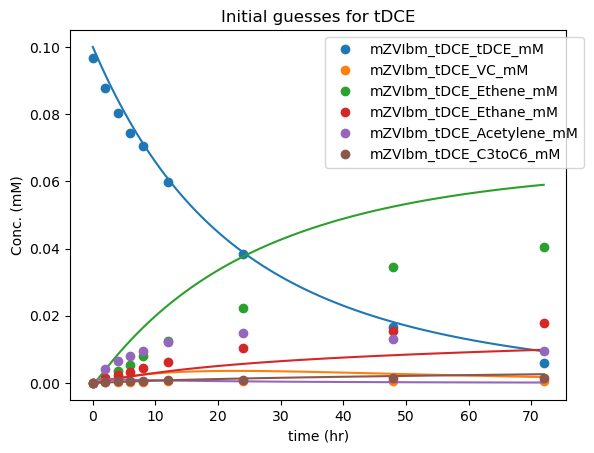

In [16]:
# Initial Guesses
karr = [0.000154913,
0.001351431,
1.66E-22,
1.25E-05,
0.000169865,
0.006572788,
0.004576002,
0.030211386,
0.010104698,
0.01538538,
0.005465666,
0,
0.070925877,
0.00031306,
2.148707611,
280.4961721,
0.325455601,
1652.376696,
7.21E-09,
8.92E-09,
6342.834443,
0.047280383,
0.000666284,
0.009,
0.041665372
]
C0 = np.zeros(1)
C0[0] = 0.1



tdata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_Time_hr']
lst1 =  dict_mZVIbm['tDCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['tDCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = tDCE(np.hstack((karr, C0)), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['tDCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.title('Initial guesses for tDCE')
# plt.savefig('Local_Corrected mZVIbm_tDCE.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
# df.to_csv('Local_Corrected mZVIbm_tDCE.csv',index=False)

In [17]:
# Perform Fit
tDCEfit = least_squares(tDCEfitfunc, np.hstack((karr, C0)), bounds=(0, np.inf))
# print(tDCEfit.x)

# Compute std errors
try:
    J = tDCEfit.jac
    chi2dof = np.sum(tDCEfit.fun**2)/(tDCEfit.fun.size - tDCEfit.x.size)
    cov = np.linalg.inv(J.T.dot(J))*chi2dof
    err = np.sqrt(np.diagonal(cov))
except:
    err = np.zeros_like(tDCEfit)*np.NaN
# print(err)

# Print results
coef_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb', 'C_0']
pd.DataFrame({'Fitted Coefs':tDCEfit.x, 'Std. Err.':err}, index=coef_names)
# pd.DataFrame(J.T.dot(J)).to_clipboard(index=False, header=False)

,Fitted Coefs,Std. Err.
k1,1.549130e-04,NaN
k2,1.351431e-03,NaN
k3,1.000000e-10,NaN
k4,1.250000e-05,NaN
k5,1.698650e-04,NaN
k6,6.572788e-03,NaN
k7,3.105209e-03,NaN
k8,2.726835e-02,NaN
k9,1.010470e-02,NaN
k10,1.538538e-02,NaN


Text(0.5, 1.0, 'Local fits for tDCE')

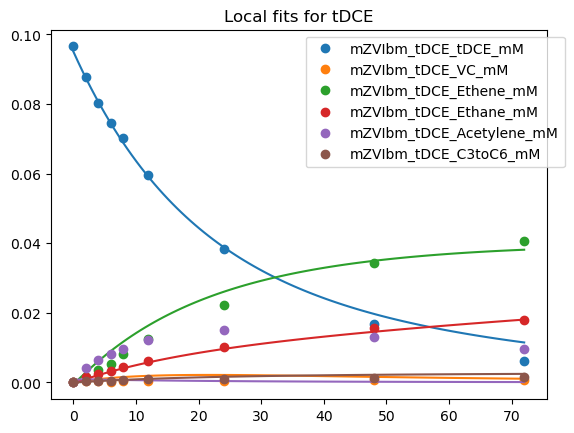

In [18]:
tdata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_Time_hr']
lst1 =  dict_mZVIbm['tDCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['tDCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = tDCE(tDCEfit.x, tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['tDCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Local fits for tDCE')

In [19]:
local_fit_df['tDCE Fit'] = tDCEfit.x

#### Local for for cDCE

In [20]:
# TCE and daughter products
def cDCE(params, tarr):
    #first 25 params are k's, Then Cinit_i = params[25]
    
    # Run model
    A = Calc_A(params[0:25])
    C0 = np.zeros(24)
    C0[4] = params[25]
    Coef = np.linalg.solve(expm(0*A), C0)
    C = np.array([np.dot(expm(a),Coef) for a in [t * A for t in tarr]])
    
    # Organize model results
    cDCEmodel = C[:,4]
    VCmodel = C[:,7]
    Ethenemodel = C[:,9]
    Ethanemodel = C[:,10]
    Acetylenemodel = C[:,8]
    C3toC6model = C[:,11]
    
    # Return Results
    return cDCEmodel, VCmodel, Ethenemodel, Ethanemodel, Acetylenemodel, C3toC6model
    
def cDCEfitfunc(params):
    #first 25 params are k's, Then Cinit_i = params[26+i]
    
    # Organize data
    tdata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_Time_hr']
    cDCEdata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_cDCE_mM']
    VCdata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_VC_mM']
    Ethenedata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_Ethene_mM']
    Ethanedata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_Ethane_mM']
    Acetylenedata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_Acetylene_mM']
    C3toC6data = dict_mZVIbm['cDCE']['mZVIbm_cDCE_C3toC6_mM']
    
    # Run model
    cDCEmodel, VCmodel, Ethenemodel, Ethanemodel, Acetylenemodel, C3toC6model = cDCE(params, tdata)

    # Formulate Residuals
    Resids = np.array([cDCEdata - cDCEmodel,
                      VCdata - VCmodel,
                      Ethenedata - Ethenemodel,
                      Ethanedata - Ethanemodel,
                      Acetylenedata - Acetylenemodel,
                      C3toC6data - C3toC6model])
    return Resids.flatten()

Text(0.5, 1.0, 'Initial guesses for cDCE')

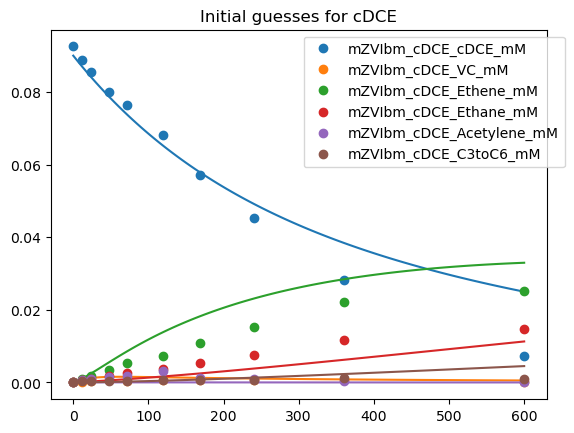

In [21]:
# Initial Guesses
karr = [0.000154913,
0.001351431,
1.66E-22,
1.25E-05,
0.000169865,
0.006572788,
0.004576002,
0.030211386,
0.001,
0.001,
0.005465666,
0,
0.070925877,
0.00031306,
2.148707611,
280.4961721,
0.325455601,
1652.376696,
7.21E-09,
8.92E-09,
6342.834443,
0.047280383,
0.000666284,
0.0009,
0.004
]
C0 = np.zeros(1)
C0[0] = 0.09



tdata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_Time_hr']
lst1 =  dict_mZVIbm['cDCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['cDCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = cDCE(np.hstack((karr, C0)), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['cDCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Initial guesses for cDCE')

In [22]:
# Perform Fit
cDCEfit = least_squares(cDCEfitfunc, np.hstack((karr, C0)), bounds=(0, np.inf))
# print(cDCEfit.x)

# Compute std errors
try:
    J = cDCEfit.jac
    chi2dof = np.sum(cDCEfit.fun**2)/(cDCEfit.fun.size - cDCEfit.x.size)
    cov = np.linalg.inv(J.T.dot(J))*chi2dof
    err = np.sqrt(np.diagonal(cov))
except:
    err = np.zeros_like(cDCEfit)*np.NaN
# print(err)

# Print results
coef_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb', 'C_0']
pd.DataFrame({'Fitted Coefs':cDCEfit.x, 'Std. Err.':err}, index=coef_names)
# pd.DataFrame(J.T.dot(J)).to_clipboard(index=False, header=False)

,Fitted Coefs,Std. Err.
k1,1.549130e-04,NaN
k2,1.351431e-03,NaN
k3,1.000000e-10,NaN
k4,1.250000e-05,NaN
k5,1.698650e-04,NaN
k6,6.572788e-03,NaN
k7,4.576002e-03,NaN
k8,3.021139e-02,NaN
k9,1.029971e-03,NaN
k10,1.169759e-03,NaN


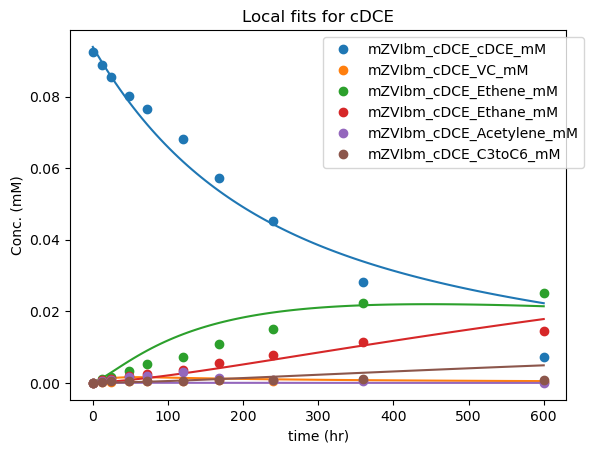

In [23]:
tdata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_Time_hr']
lst1 =  dict_mZVIbm['cDCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['cDCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = cDCE(cDCEfit.x, tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['cDCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.title('Local fits for cDCE')
# plt.savefig('Local_Corrected mZVIbm_cDCE.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
# df.to_csv('Local_Corrected mZVIbm_cDCE.csv',index=False)

In [24]:
local_fit_df['cDCE Fit'] = cDCEfit.x

#### Local fits for gDCE

In [25]:
# TCE and daughter products
def gDCE(params, tarr):
    #first 25 params are k's, Then Cinit_i = params[25]
    
    # Run model
    A = Calc_A(params[0:25])
    C0 = np.zeros(24)
    C0[5] = params[25]
    Coef = np.linalg.solve(expm(0*A), C0)
    C = np.array([np.dot(expm(a),Coef) for a in [t * A for t in tarr]])
    
    # Organize model results
    gDCEmodel = C[:,5]
    VCmodel = C[:,7]
    Ethenemodel = C[:,9]
    Ethanemodel = C[:,10]
    C3toC6model = C[:,11]
    
    # Return Results
    return gDCEmodel, VCmodel, Ethenemodel, Ethanemodel, C3toC6model
    
def gDCEfitfunc(params):
    #first 25 params are k's, Then Cinit_i = params[26+i]
    
    # Organize data
    tdata = dict_mZVIbm['11DCE']['mZVIbm_11DCE_Time_hr']
    gDCEdata = dict_mZVIbm['11DCE']['mZVIbm_11DCE_11DCE_mM']
    VCdata = dict_mZVIbm['11DCE']['mZVIbm_11DCE_VC_mM']
    Ethenedata = dict_mZVIbm['11DCE']['mZVIbm_11DCE_Ethene_mM']
    Ethanedata = dict_mZVIbm['11DCE']['mZVIbm_11DCE_Ethane_mM']
    C3toC6data = dict_mZVIbm['11DCE']['mZVIbm_11DCE_C3toC6_mM']
    
    # Run model
    gDCEmodel, VCmodel, Ethenemodel, Ethanemodel, C3toC6model = gDCE(params, tdata)

    # Formulate Residuals
    Resids = np.array([gDCEdata - gDCEmodel,
                      VCdata - VCmodel,
                      Ethenedata - Ethenemodel,
                      Ethanedata - Ethanemodel,
                      C3toC6data - C3toC6model])
    return Resids.flatten()

Text(0.5, 1.0, 'Initial guesses for gDCE')

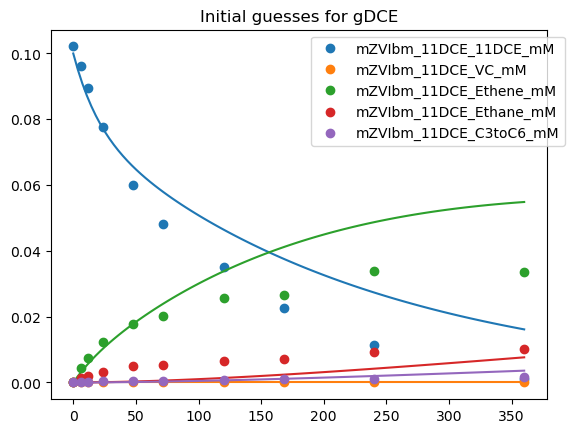

In [26]:
# Initial Guesses
karr = [0.000154913,
0.001351431,
1.66E-22,
1.25E-05,
0.000169865,
0.006572788,
0.004576002,
0.030211386,
0.010104698,
0.01538538,
0.005465666,
0,
0.070925877,
0.00031306,
2.148707611,
280.4961721,
0.325455601,
1652.376696,
7.21E-09,
8.92E-09,
6342.834443,
0.047280383,
0.000666284,
0.009,
0.041665372
]
C0 = np.zeros(1)
C0[0] = 0.1



tdata = dict_mZVIbm['11DCE']['mZVIbm_11DCE_Time_hr']
lst1 =  dict_mZVIbm['11DCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['11DCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = gDCE(np.hstack((karr, C0)), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['11DCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Initial guesses for gDCE')

In [27]:
# Perform Fit
gDCEfit = least_squares(gDCEfitfunc, np.hstack((karr, C0)), bounds=(0, np.inf))
# print(gDCEfit.x)

# Compute std errors
try:
    J = gDCEfit.jac
    chi2dof = np.sum(gDCEfit.fun**2)/(gDCEfit.fun.size - gDCEfit.x.size)
    cov = np.linalg.inv(J.T.dot(J))*chi2dof
    err = np.sqrt(np.diagonal(cov))
except:
    err = np.zeros_like(gDCEfit)*np.NaN
# print(err)

# Print results
coef_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb', 'C_0']
pd.DataFrame({'Fitted Coefs':gDCEfit.x, 'Std. Err.':err}, index=coef_names)
# pd.DataFrame(J.T.dot(J)).to_clipboard(index=False, header=False)

,Fitted Coefs,Std. Err.
k1,1.549130e-04,NaN
k2,1.351431e-03,NaN
k3,1.000000e-10,NaN
k4,1.250000e-05,NaN
k5,1.698650e-04,NaN
k6,6.572788e-03,NaN
k7,4.576002e-03,NaN
k8,3.021139e-02,NaN
k9,1.010470e-02,NaN
k10,1.538538e-02,NaN


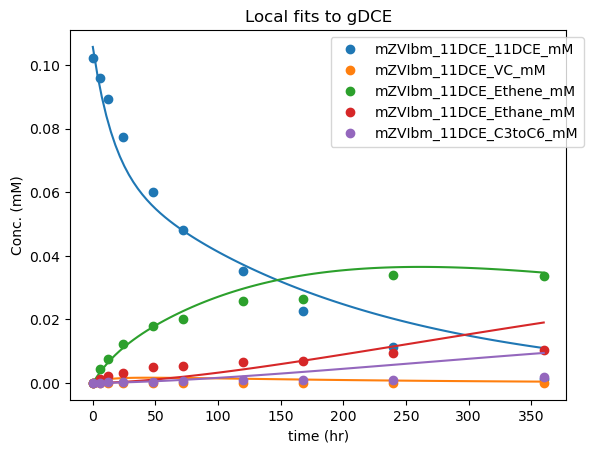

In [28]:
tdata = dict_mZVIbm['11DCE']['mZVIbm_11DCE_Time_hr']
lst1 =  dict_mZVIbm['11DCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['11DCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = gDCE(gDCEfit.x, tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['11DCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.title('Local fits to gDCE')
# plt.savefig('Local_Corrected mZVIbm_11DCE.png',bbox_inches ="tight")


d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
# df.to_csv('Local_Corrected mZVIbm_11DCE.csv',index=False)

In [29]:
local_fit_df['gDCE Fit'] = gDCEfit.x

#### Local fit of VC

In [30]:
# VC and daughter products
def VC(params, tarr):
    #first 25 params are k's, Then Cinit_i = params[25]
    
    # Run model
    A = Calc_A(params[0:25])
    C0 = np.zeros(24)
    C0[7] = params[25]
    Coef = np.linalg.solve(expm(0*A), C0)
    C = np.array([np.dot(expm(a),Coef) for a in [t * A for t in tarr]])
    
    # Organize model results
    VCmodel = C[:,7]
    Ethenemodel = C[:,9]
    Ethanemodel = C[:,10]
    C3toC6model = C[:,11]
    
    # Return Results
    return VCmodel, Ethenemodel, Ethanemodel, C3toC6model
    
def VCfitfunc(params):
    #first 25 params are k's, Then Cinit_i = params[26+i]
    
    # Organize data
    tdata = dict_mZVIbm['VC']['mZVIbm_VC_Time_hr']
    VCdata = dict_mZVIbm['VC']['mZVIbm_VC_VC_mM']
    Ethenedata = dict_mZVIbm['VC']['mZVIbm_VC_Ethene_mM']
    Ethanedata = dict_mZVIbm['VC']['mZVIbm_VC_Ethane_mM']
    C3toC6data = dict_mZVIbm['VC']['mZVIbm_VC_C3toC6_mM']
    
    # Run model
    VCmodel, Ethenemodel, Ethanemodel, C3toC6model = VC(params, tdata)

    # Formulate Residuals
    Resids = np.array([VCdata - VCmodel,
                      Ethenedata - Ethenemodel,
                      Ethanedata - Ethanemodel,
                      C3toC6data - C3toC6model])
    return Resids.flatten()

Text(0.5, 1.0, 'Initial guesses for VC')

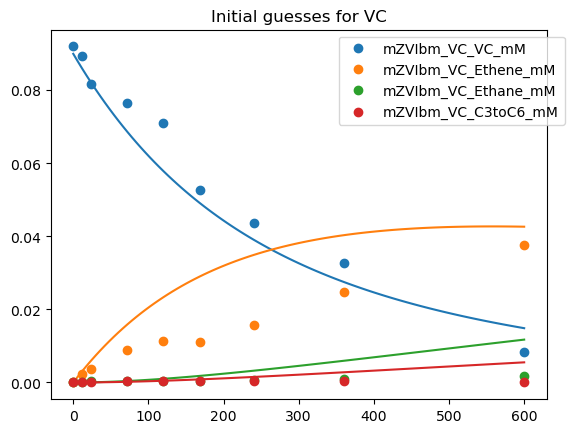

In [31]:
# Initial Guesses
karr = [0.000154913,
0.001351431,
1.66E-22,
1.25E-05,
0.000169865,
0.006572788,
0.004576002,
0.030211386,
0.010104698,
0.01538538,
0.005465666,
0,
0.070925877,
0.00031306,
2.148707611,
280.4961721,
0.325455601,
1652.376696,
7.21E-09,
8.92E-09,
6342.834443,
0.003,
0.000666284,
0.0009,
0.0041665372
]
C0 = np.zeros(1)
C0[0] = 0.09



tdata = dict_mZVIbm['VC']['mZVIbm_VC_Time_hr']
lst1 =  dict_mZVIbm['VC'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['VC'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = VC(np.hstack((karr, C0)), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['VC'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Initial guesses for VC')

In [32]:
# Perform Fit
VCfit = least_squares(VCfitfunc, np.hstack((karr, C0)), bounds=(0, np.inf))
# print(VCfit.x)

# Compute std errors
try:
    J = VCfit.jac
    chi2dof = np.sum(VCfit.fun**2)/(VCfit.fun.size - VCfit.x.size)
    cov = np.linalg.inv(J.T.dot(J))*chi2dof
    err = np.sqrt(np.diagonal(cov))
except:
    err = np.zeros_like(VCfit)*np.NaN
# print(err)

# Print results
coef_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb', 'C_0']
pd.DataFrame({'Fitted Coefs':VCfit.x, 'Std. Err.':err}, index=coef_names)
# pd.DataFrame(J.T.dot(J)).to_clipboard(index=False, header=False)

,Fitted Coefs,Std. Err.
k1,1.549130e-04,NaN
k2,1.351431e-03,NaN
k3,1.000000e-10,NaN
k4,1.250000e-05,NaN
k5,1.698650e-04,NaN
k6,6.572788e-03,NaN
k7,4.576002e-03,NaN
k8,3.021139e-02,NaN
k9,1.010470e-02,NaN
k10,1.538538e-02,NaN


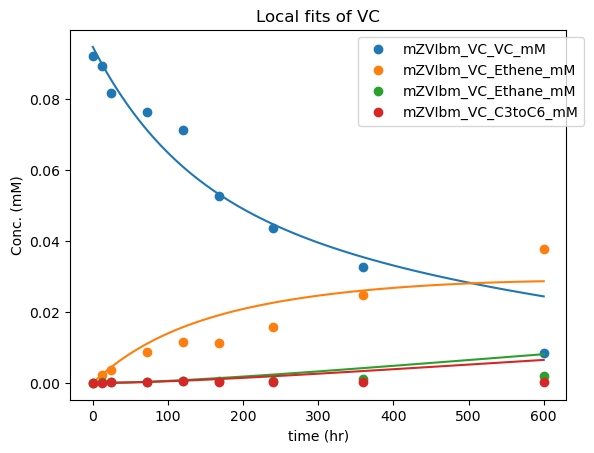

In [33]:
tdata = dict_mZVIbm['VC']['mZVIbm_VC_Time_hr']
lst1 =  dict_mZVIbm['VC'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['VC'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = VC(VCfit.x, tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['VC'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.title('Local fits of VC')
# plt.savefig('Local_Corrected mZVIbm_VC.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
# df.to_csv('Local_Corrected mZVIbm_VC.csv',index=False)

In [34]:
local_fit_df['VC Fit'] = VCfit.x

#### Local fit of Acetylene

In [35]:
# Acetylene and daughter products
def Acetylene(params, tarr):
    #first 25 params are k's, Then Cinit_i = params[25]
    
    # Run model
    A = Calc_A(params[0:25])
    C0 = np.zeros(24)
    C0[8] = params[25]
    Coef = np.linalg.solve(expm(0*A), C0)
    C = np.array([np.dot(expm(a),Coef) for a in [t * A for t in tarr]])
    
    # Organize model results
    Acetylenemodel = C[:,8]
    Ethenemodel = C[:,9]
    Ethanemodel = C[:,10]
    C3toC6model = C[:,11]
    
    # Return Results
    return Acetylenemodel, Ethenemodel, Ethanemodel, C3toC6model
    
def Acetylenefitfunc(params):
    #first 25 params are k's, Then Cinit_i = params[26+i]
    
    # Organize data
    tdata = dict_mZVIbm['Acetylene']['mZVIbm_Acetylene_Time_hr']
    Acetylenedata = dict_mZVIbm['Acetylene']['mZVIbm_Acetylene_Acetylene_mM']
    Ethenedata = dict_mZVIbm['Acetylene']['mZVIbm_Acetylene_Ethene_mM']
    Ethanedata = dict_mZVIbm['Acetylene']['mZVIbm_Acetylene_Ethane_mM']
    C3toC6data = dict_mZVIbm['Acetylene']['mZVIbm_Acetylene_C3toC6_mM']
    
    # Run model
    Acetylenemodel, Ethenemodel, Ethanemodel, C3toC6model = Acetylene(params, tdata)

    # Formulate Residuals
    Resids = np.array([Acetylenedata - Acetylenemodel,
                      Ethenedata - Ethenemodel,
                      Ethanedata - Ethanemodel,
                      C3toC6data - C3toC6model])
    return Resids.flatten()

Text(0.5, 1.0, 'Initial guesses for Acetylene')

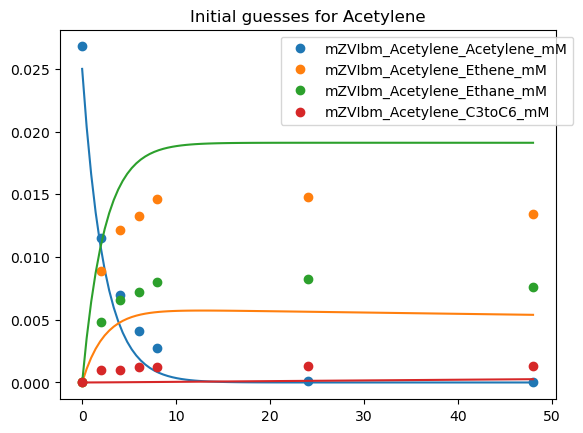

In [36]:
# Initial Guesses
karr = [0.000154913,
0.001351431,
1.66E-22,
1.25E-05,
0.000169865,
0.006572788,
0.004576002,
0.030211386,
0.010104698,
0.01538538,
0.005465666,
0,
0.0001,
0.001,
0.1,
280.4961721,
0.325455601,
1652.376696,
7.21E-09,
8.92E-09,
6342.834443,
0.047280383,
0.000666284,
0.0002,
0.00041665372
]
C0 = np.zeros(1)
C0[0] = 0.025



tdata = dict_mZVIbm['Acetylene']['mZVIbm_Acetylene_Time_hr']
lst1 =  dict_mZVIbm['Acetylene'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['Acetylene'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = Acetylene(np.hstack((karr, C0)), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['Acetylene'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Initial guesses for Acetylene')

In [37]:
# Perform Fit
Acetylenefit = least_squares(Acetylenefitfunc, np.hstack((karr, C0)), bounds=(0, np.inf))
# print(Acetylenefit.x)

# Compute std errors
try:
    J = Acetylenefit.jac
    chi2dof = np.sum(Acetylenefit.fun**2)/(Acetylenefit.fun.size - Acetylenefit.x.size)
    cov = np.linalg.inv(J.T.dot(J))*chi2dof
    err = np.sqrt(np.diagonal(cov))
except:
    err = np.zeros_like(Acetylenefit)*np.NaN
# print(err)

# Print results
coef_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb', 'C_0']
pd.DataFrame({'Fitted Coefs':Acetylenefit.x, 'Std. Err.':err}, index=coef_names)
# pd.DataFrame(J.T.dot(J)).to_clipboard(index=False, header=False)

,Fitted Coefs,Std. Err.
k1,1.549130e-04,NaN
k2,1.351431e-03,NaN
k3,1.000000e-10,NaN
k4,1.250000e-05,NaN
k5,1.698650e-04,NaN
k6,6.572788e-03,NaN
k7,4.576002e-03,NaN
k8,3.021139e-02,NaN
k9,1.010470e-02,NaN
k10,1.538538e-02,NaN


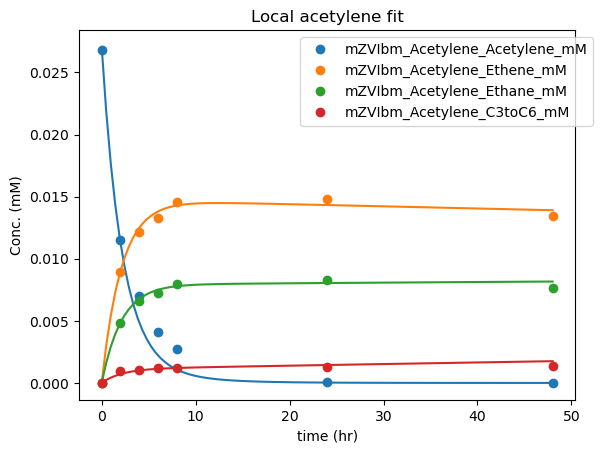

In [38]:
tdata = dict_mZVIbm['Acetylene']['mZVIbm_Acetylene_Time_hr']
lst1 =  dict_mZVIbm['Acetylene'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['Acetylene'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = Acetylene(Acetylenefit.x, tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['Acetylene'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.title('Local acetylene fit')
# plt.savefig('Local_Corrected mZVIbm_Acetylene.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
# df.to_csv('Local_Corrected mZVIbm_Acetylene.csv',index=False)

In [39]:
local_fit_df['Acetylene Fit'] = Acetylenefit.x

#### Local fit of Ethene

In [40]:
# TCE and daughter products
def Ethene(params, tarr):
    #first 25 params are k's, Then Cinit_i = params[25]
    
    # Run model
    A = Calc_A(params[0:25])
    C0 = np.zeros(24)
    C0[9] = params[25]
    Coef = np.linalg.solve(expm(0*A), C0)
    C = np.array([np.dot(expm(a),Coef) for a in [t * A for t in tarr]])
    
    # Organize model results
    Ethenemodel = C[:,9]
    Ethanemodel = C[:,10]
    
    # Return Results
    return Ethenemodel, Ethanemodel
    
def Ethenefitfunc(params):
    #first 25 params are k's, Then Cinit_i = params[26+i]
    
    # Organize data
    tdata = dict_mZVIbm['Ethene']['mZVIbm_Ethene_Time_hr']
    Ethenedata = dict_mZVIbm['Ethene']['mZVIbm_Ethene_Ethene_mM']
    Ethanedata = dict_mZVIbm['Ethene']['mZVIbm_Ethene_Ethane_mM']
    
    # Run model
    Ethenemodel, Ethanemodel = Ethene(params, tdata)

    # Formulate Residuals
    Resids = np.array([Ethenedata - Ethenemodel,
                      Ethanedata - Ethanemodel])
    return Resids.flatten()

Text(0.5, 1.0, 'Initial guesses for ethene')

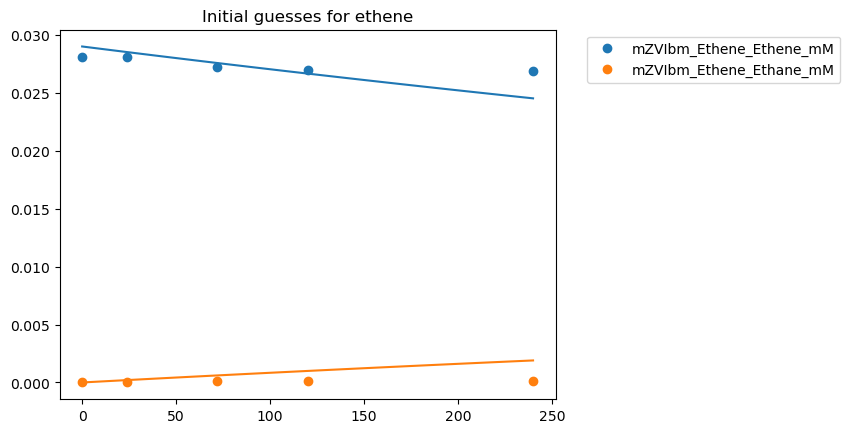

In [41]:
# Initial Guesses
karr = [0.000154913,
0.001351431,
1.66E-22,
1.25E-05,
0.000169865,
0.006572788,
0.004576002,
0.030211386,
0.010104698,
0.01538538,
0.005465666,
0,
0.070925877,
0.00031306,
2.148707611,
280.4961721,
0.325455601,
1652.376696,
7.21E-09,
8.92E-09,
6342.834443,
0.047280383,
0.0003,
0.00009,
0.0004
]
C0 = np.zeros(1)
C0[0] = 0.029



tdata = dict_mZVIbm['Ethene']['mZVIbm_Ethene_Time_hr']
lst1 =  dict_mZVIbm['Ethene'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['Ethene'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = Ethene(np.hstack((karr, C0)), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['Ethene'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Initial guesses for ethene')

In [42]:
# Perform Fit
Ethenefit = least_squares(Ethenefitfunc, np.hstack((karr, C0)), bounds=(0, np.inf))
# print(Ethenefit.x)

# Compute std errors
try:
    J = Ethenefit.jac
    chi2dof = np.sum(Ethenefit.fun**2)/(Ethenefit.fun.size - Ethenefit.x.size)
    cov = np.linalg.inv(J.T.dot(J))*chi2dof
    err = np.sqrt(np.diagonal(cov))
except:
    err = np.zeros_like(Ethenefit)*np.NaN
# print(err)

# Print results
coef_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb', 'C_0']
pd.DataFrame({'Fitted Coefs':Ethenefit.x, 'Std. Err.':err}, index=coef_names)
# pd.DataFrame(J.T.dot(J)).to_clipboard(index=False, header=False)

,Fitted Coefs,Std. Err.
k1,1.549130e-04,NaN
k2,1.351431e-03,NaN
k3,1.000000e-10,NaN
k4,1.250000e-05,NaN
k5,1.698650e-04,NaN
k6,6.572788e-03,NaN
k7,4.576002e-03,NaN
k8,3.021139e-02,NaN
k9,1.010470e-02,NaN
k10,1.538538e-02,NaN


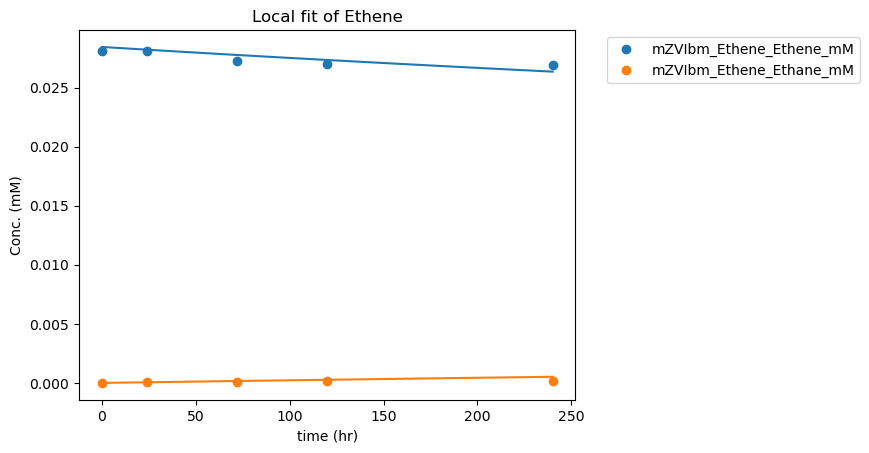

In [43]:
tdata = dict_mZVIbm['Ethene']['mZVIbm_Ethene_Time_hr']
lst1 =  dict_mZVIbm['Ethene'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['Ethene'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = Ethene(Ethenefit.x, tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['Ethene'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.title('Local fit of Ethene')
# plt.savefig('Local_Corrected mZVIbm_Ethene.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
# df.to_csv('Local_Corrected mZVIbm_Ethene.csv',index=False)

In [44]:
local_fit_df['Ethene Fit'] = Ethenefit.x

# Global Fitting
Weight the residuals by Co

In [45]:
# Initial parameter set
# Median k values from local fitting
karr = np.array(local_fit_df.iloc[:-1].median(axis=1))
# C0 values from local fits
C0 = np.array(local_fit_df.loc['C_0'])

# Fit function based on pooled residuals from local fit functions
def WghtGLBLfitfunc(GLBLparams):
    #first 25 GLBLparams are k's, 
    # Hold the C0 values for PCE, TCE, tDCE, cDCE, gDCE, VC, Acetylene, Ethene
    # Create parameter array for use in each local fitfunc
    params = np.zeros(26)
    params[0:25] = GLBLparams[0:25]
    # PCE
    params[25] = C0[0] #GLBLparams[25]
    PCEresids = PCEfitfunc(params)/C0[0]
    # TCE
    params[25] = C0[1] #GLBLparams[26]
    TCEresids = TCEfitfunc(params)/C0[1]
    # tDCE
    params[25] = C0[2] #GLBLparams[27]
    tDCEresids = tDCEfitfunc(params)/C0[2]
    # cDCE
    params[25] = C0[3] #GLBLparams[28]
    cDCEresids = cDCEfitfunc(params)/C0[3]
    # gDCE
    params[25] = C0[4] #GLBLparams[29]
    gDCEresids = gDCEfitfunc(params)/C0[4]
    # VC
    params[25] = C0[5] #GLBLparams[30]
    VCresids = VCfitfunc(params)/C0[5]
    # Acetylene
    params[25] = C0[6] #GLBLparams[31]
    Acetyleneresids = Acetylenefitfunc(params)/C0[6]
    # Ethene
    params[25] = C0[7] #GLBLparams[3]
    Etheneresids = Ethenefitfunc(params)/C0[7]
    
    Resids = np.hstack((PCEresids, TCEresids, tDCEresids, cDCEresids, gDCEresids, VCresids, Acetyleneresids, Etheneresids))
    return Resids

In [46]:
# Execute global fit
WghtGLBLfit = least_squares(WghtGLBLfitfunc, karr, bounds=(0, np.inf))

# Compute paramter error estimates
J = WghtGLBLfit.jac
chi2dof = np.sum(WghtGLBLfit.fun**2)/(WghtGLBLfit.fun.size - WghtGLBLfit.x.size)
cov = np.linalg.inv(J.T.dot(J))*chi2dof
err = np.sqrt(np.diagonal(cov))

# print results
glbl_fits = pd.DataFrame({'Coefs':WghtGLBLfit.x, 'Std Err':err},
             index=['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k11b', 'k12', 'k12b', 'k13', 'k13b', 'k13c', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'kLf', 'kLb'])
glbl_fits

,Coefs,Std Err
k1,1.851223e-03,2.237968e-03
k2,3.885656e-03,2.229215e-03
k3,1.254331e-03,2.909160e-03
k4,7.478868e-03,2.248644e-03
k5,1.546746e-03,2.310075e-03
k6,7.388857e-02,5.160172e-03
k7,1.959577e-03,9.026405e-04
k8,3.150904e-02,1.674316e-03
k9,1.970153e-27,1.452651e-04
k10,1.925435e-03,1.716087e-04


#### Plot global fit results
Also, save fitted curves to csv

In [47]:
# Path to directory for saving fits
pth = r'PCE_data\Data on 10.10.23\Fitting Results\Fits to Dechlorination data S(0.02)-mZVIbm-background corrected-2023.09.25-4places'

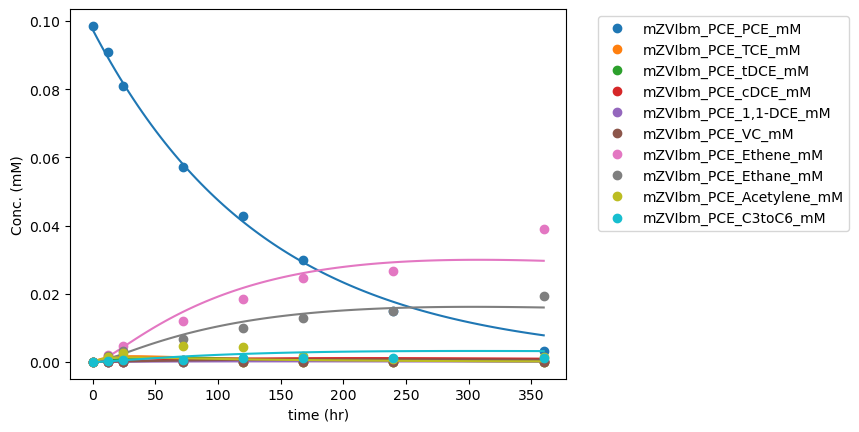

In [48]:
tdata = dict_mZVIbm['PCE']['mZVIbm_PCE_Time_hr']
lst1 =  dict_mZVIbm['PCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['PCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = PCE(np.hstack((WghtGLBLfit.x, C0[0])), tarr)


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],2), C)):
    plt.plot(tdata, dict_mZVIbm['PCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.savefig(pth + r'\Corrected mZVIbm_PCE.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],2), C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)

df.to_csv(pth + r'\Corrected mZVIbm_PCE.csv',index=False)
# df.to_excel("model_mZVIbm.xlsx", sheet_name='PCE', index=False) 

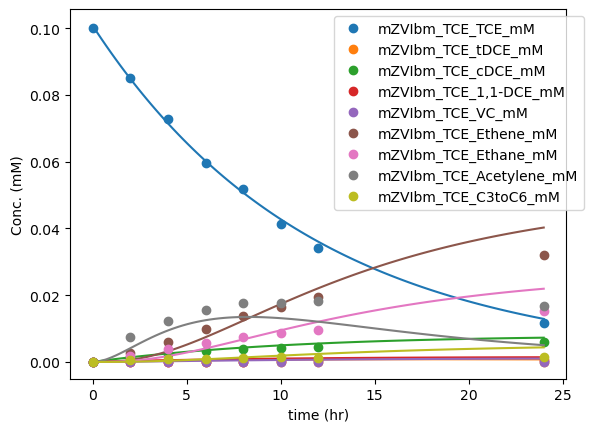

In [49]:
tdata = dict_mZVIbm['TCE']['mZVIbm_TCE_Time_hr']
lst1 =  dict_mZVIbm['TCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['TCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = TCE(np.hstack((WghtGLBLfit.x, C0[1])), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],1), C)):
    plt.plot(tdata, dict_mZVIbm['TCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.savefig(pth + r'\Corrected mZVIbm_TCE.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(np.delete(lst1[lst2],1), C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
df.to_csv(pth + r'\Corrected mZVIbm_TCE.csv',index=False)
# df.to_excel("model_mZVIbm.xlsx", sheet_name='TCE', index=False) 

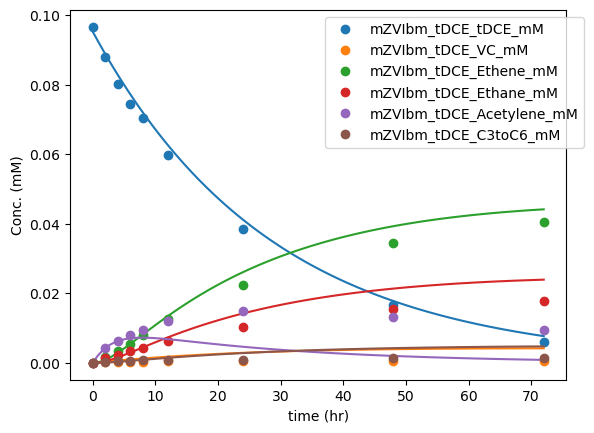

In [57]:
tdata = dict_mZVIbm['tDCE']['mZVIbm_tDCE_Time_hr']
lst1 =  dict_mZVIbm['tDCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['tDCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = tDCE(np.hstack((WghtGLBLfit.x, C0[2])), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['tDCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.savefig(pth + r'\Corrected mZVIbm_tDCE.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
df.to_csv(pth + r'\Corrected mZVIbm_tDCE.csv',index=False)
# df.to_excel("model_mZVIbm.xlsx", sheet_name='cDCE', index=False) 

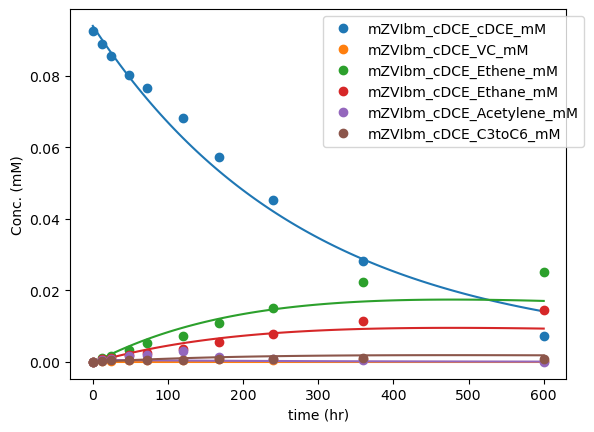

In [51]:
tdata = dict_mZVIbm['cDCE']['mZVIbm_cDCE_Time_hr']
lst1 =  dict_mZVIbm['cDCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['cDCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = cDCE(np.hstack((WghtGLBLfit.x, C0[3])), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['cDCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.savefig(pth + r'\Corrected mZVIbm_cDCE.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
df.to_csv(pth + r'\Corrected mZVIbm_cDCE.csv',index=False)
# df.to_excel("model_mZVIbm.xlsx", sheet_name='cDCE', index=False) 

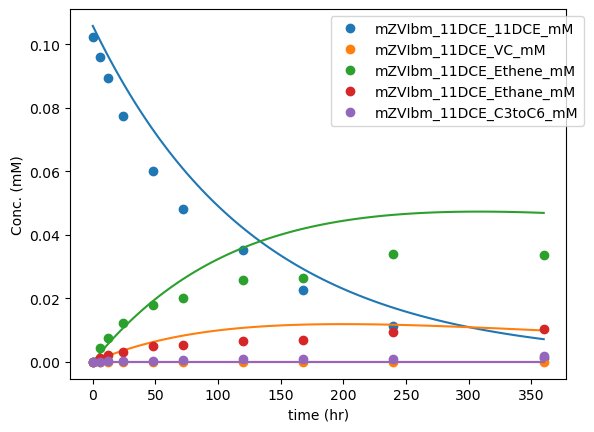

In [52]:
tdata = dict_mZVIbm['11DCE']['mZVIbm_11DCE_Time_hr']
lst1 =  dict_mZVIbm['11DCE'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['11DCE'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = gDCE(np.hstack((WghtGLBLfit.x, C0[4])), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['11DCE'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.savefig(pth + r'\Corrected mZVIbm_11DCE.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
df.to_csv(pth + r'\Corrected mZVIbm_11DCE.csv',index=False)
# df.to_excel("model_mZVIbm.xlsx", sheet_name='11DCE', index=False) 

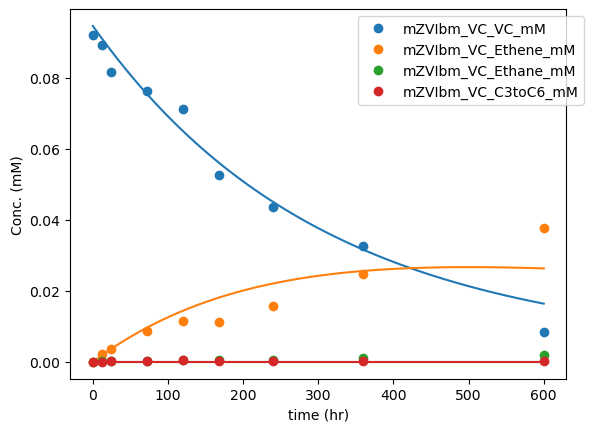

In [53]:
tdata = dict_mZVIbm['VC']['mZVIbm_VC_Time_hr']
lst1 =  dict_mZVIbm['VC'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['VC'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = VC(np.hstack((WghtGLBLfit.x, C0[5])), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['VC'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.savefig(pth + r'\Corrected mZVIbm_VC.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
df.to_csv(pth + r'\Corrected mZVIbm_VC.csv',index=False)
# df.to_excel("model_mZVIbm.xlsx", sheet_name='VC', index=False) 

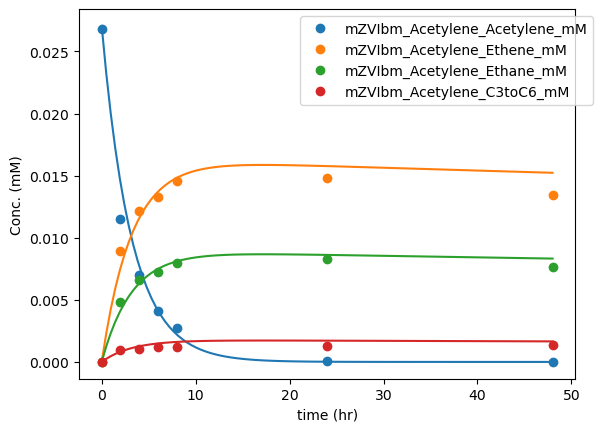

In [54]:
tdata = dict_mZVIbm['Acetylene']['mZVIbm_Acetylene_Time_hr']
lst1 =  dict_mZVIbm['Acetylene'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['Acetylene'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = Acetylene(np.hstack((WghtGLBLfit.x, C0[6])), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['Acetylene'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.savefig(pth + r'\Corrected mZVIbm_Acetylene.png',bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
df.to_csv(pth + r'\Corrected mZVIbm_Acetylene.csv',index=False)
# df.to_excel("model_mZVIbm.xlsx", sheet_name='Acetylene', index=False) 

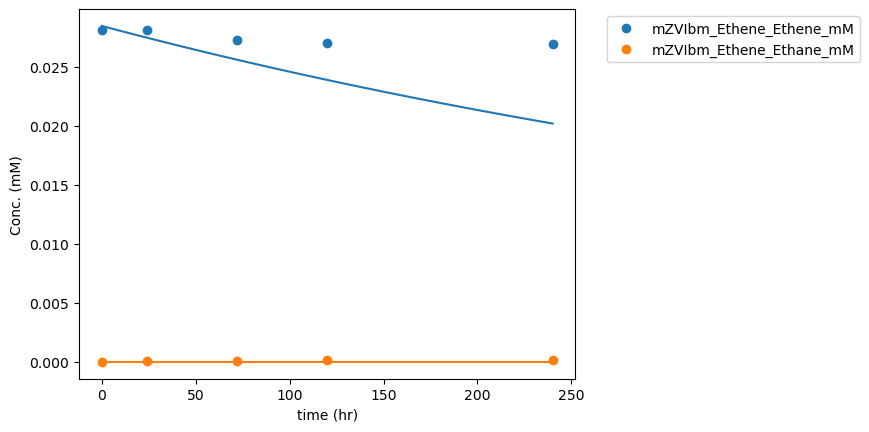

In [55]:
tdata = dict_mZVIbm['Ethene']['mZVIbm_Ethene_Time_hr']
lst1 =  dict_mZVIbm['Ethene'].columns.values
lst2 = [s.endswith('mM') for s in dict_mZVIbm['Ethene'].columns.values]

tarr = np.linspace(tdata.iloc[0],tdata.iloc[-1],101)
C = Ethene(np.hstack((WghtGLBLfit.x, C0[7])), tarr)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']    
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    plt.plot(tdata, dict_mZVIbm['Ethene'][name], 'o', color=colors[i], label = name)
    plt.plot(tarr, conc, color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('time (hr)')
plt.ylabel('Conc. (mM)')
plt.savefig(pth + r'\Corrected mZVIbm_Ethene.png', bbox_inches ="tight")

d = {'model_'+lst1[0]: tarr}
for i, (name, conc) in enumerate(zip(lst1[lst2], C)):
    d['model_' + name] = conc
df = pd.DataFrame(data=d)
df.to_csv(pth + r'\Corrected mZVIbm_Ethene.csv',index=False)
# df.to_excel("model_mZVIbm.xlsx", sheet_name='Ethene', index=False) 

In [55]:
glbl_fits.to_clipboard(index=False)